In [85]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pickle

In [115]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv') #Import raw data
df = df.set_index('name') #Index each observation by the Car Model
df['selling_price'] =  df['selling_price']/82.41#Convert Rupees to USD
df['owner'] = df['owner'].apply(lambda x:0 if x == "First Owner" else 1).astype(int) # 0 means one previous owner (car is on the newer side)
# 1 means two or more previous owner and car is on the older side. This definition seems clear and more simplified
df['fuel'] = df['fuel'].apply(lambda x:'Petrol' if x == 'Petrol' else ('Diesel' if x == 'Diesel' else 'Other'))
#Simplify fuel types into 3 categories. Any fuel type that isn't petrol/diesel make up <10% of the dataset and should be lumped as other instead
df = pd.get_dummies(df, columns = ['fuel','seller_type','transmission']) #Make dummy variables for categorical variables so we can model with the data
df['year'] = 2023 - df['year'] #Transform year column into a variable representing a car's age
df.columns.values[0] = 'Age'
owner = df.pop('owner') #Move owner column to front
df.insert(0,'owner',owner)
for i in ['Age','selling_price','km_driven']: #Standardize and scale these columns so k-NN will perform better
    df[i] = (df[i]-df[i].mean())/df[i].std()
df

,owner,Age,selling_price,km_driven,fuel_Diesel,fuel_Other,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual
name,,,,,,,,,,,,
Maruti 800 AC,0,1.444908,-0.767658,0.081130,0,0,1,0,1,0,0,1
Maruti Wagon R LXI Minor,0,1.444908,-0.638023,-0.347649,0,0,1,0,1,0,0,1
Hyundai Verna 1.6 SX,0,0.258765,0.165712,0.724298,1,0,0,0,1,0,0,1
Datsun RediGO T Option,0,-0.927378,-0.439250,-0.433405,0,0,1,0,1,0,0,1
Honda Amaze VX i-DTEC,1,-0.215692,-0.093557,1.603294,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
Hyundai i20 Magna 1.4 CRDi (Diesel),1,-0.215692,-0.162697,0.295519,1,0,0,0,1,0,0,1
Hyundai i20 Magna 1.4 CRDi,1,-0.215692,-0.162697,0.295519,1,0,0,0,1,0,0,1
Maruti 800 AC BSIII,1,0.970451,-0.681234,0.359836,0,0,1,0,1,0,0,1


In [116]:
ones = df[df['owner'] == 1]

In [117]:
zeros = df[df['owner'] == 0].sample(1508, replace = False, random_state = 0)

In [118]:
df = pd.concat([zeros,ones])

# k-NN (Best Classifcation Model)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size = .2, random_state = 0) #Split dataset

In [120]:
Accuracy = {}
for i in range(1,1000,2): #Allow k to be odd to prevent ties #Compare accuracy among different k
    knn = KNeighborsClassifier(n_neighbors=i) 
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    Accuracy[i] = accuracy_score(y_test,y_pred)

In [121]:
k = np.array(list(Accuracy.keys())) #hyperparameter k
Acc = np.array(list(Accuracy.values())) #Corresponding Accuracy Values

In [122]:
Acc.argmax()

12

In [123]:
k[12]

25

[Text(0.5, 1.0, 'k-NN Accuracy Plot'),
 Text(0.5, 0, 'k'),
 Text(0, 0.5, 'Accuracy')]

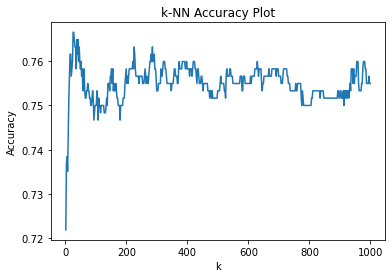

In [124]:
ax = sns.lineplot(x = k, y = Acc) #Visualize the values of k and their corresponding accuracy
ax.set(title = 'k-NN Accuracy Plot',xlabel = 'k',ylabel = 'Accuracy')#k = 13 works the best

In [125]:
knn = KNeighborsClassifier(n_neighbors=25) #Model works best when k = 13 now fit the model
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       320
           1       0.73      0.81      0.76       284

    accuracy                           0.77       604
   macro avg       0.77      0.77      0.77       604
weighted avg       0.77      0.77      0.77       604



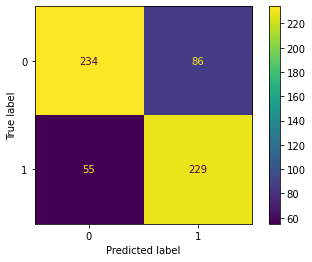

In [126]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
cm.plot()

In [127]:
CV = cross_validate(knn,df.iloc[:,1:], df.iloc[:,0], cv=10, scoring=['accuracy']) #Ensure model generalizes well by checking 10-fold CV
print('Accuracy')
print(CV['test_accuracy'])
print('Average Accuracy = ', sum(CV['test_accuracy']) / len(CV['test_accuracy']))

Accuracy
[0.7615894  0.71192053 0.81456954 0.75827815 0.79801325 0.70198675
 0.73089701 0.72093023 0.72757475 0.78405316]
Average Accuracy =  0.75098127653957


In [128]:
pickle.dump(knn, open("knn.pkl", "wb"))

In [129]:
df.max(axis = 0)

owner                            1.000000
Age                              5.003336
selling_price                   14.511954
km_driven                       10.586209
fuel_Diesel                      1.000000
fuel_Other                       1.000000
fuel_Petrol                      1.000000
seller_type_Dealer               1.000000
seller_type_Individual           1.000000
seller_type_Trustmark Dealer     1.000000
transmission_Automatic           1.000000
transmission_Manual              1.000000
dtype: float64

In [130]:
df.min(axis = 0)

owner                           0.000000
Age                            -1.639064
selling_price                  -0.836796
km_driven                      -1.419574
fuel_Diesel                     0.000000
fuel_Other                      0.000000
fuel_Petrol                     0.000000
seller_type_Dealer              0.000000
seller_type_Individual          0.000000
seller_type_Trustmark Dealer    0.000000
transmission_Automatic          0.000000
transmission_Manual             0.000000
dtype: float64

# Logistic Regression

In [131]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv') #Import raw data
df = df.set_index('name') #Index each observation by the Car Model
df['selling_price'] =  df['selling_price']/82.41#Convert Rupees to USD
df['owner'] = df['owner'].apply(lambda x:0 if x == "First Owner" else 1).astype(int) # 0 means one previous owner (car is on the newer side)
# 1 means two or more previous owner and car is on the older side. This definition seems clear and more simplified
df['fuel'] = df['fuel'].apply(lambda x:'Petrol' if x == 'Petrol' else ('Diesel' if x == 'Diesel' else 'Other'))
#Simplify fuel types into 3 categories. Any fuel type that isn't petrol/diesel make up <10% of the dataset and should be lumped as other instead
df = pd.get_dummies(df, columns = ['fuel','seller_type','transmission']) #Make dummy variables for categorical variables so we can model with the data
df['year'] = 2023 - df['year'] #Transform year column into a variable representing a car's age
df.columns.values[0] = 'Age'
owner = df.pop('owner') #Move owner column to front
df.insert(0,'owner',owner)
ros = RandomOverSampler() #Balance the dataset
X_os, y_os = ros.fit_resample(df.iloc[:,1:], df.iloc[:,0])
X_os.insert(0,'Owners',y_os)
df = X_os
for i in ['Age','selling_price','km_driven']: #Standardize and scale these columns so k-NN will perform better
    df[i] = (df[i]-df[i].mean())/df[i].std()
df = df.drop(columns = ['transmission_Automatic','seller_type_Trustmark Dealer','fuel_Other']) #Drop some dummy variables so we
#have k - 1 variables for k levels and to prevent Singularity Issues

In [132]:
df

,Owners,Age,selling_price,km_driven,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Manual
0,0,1.272305,-0.747826,-0.006690,0,1,0,1,1
1,0,1.272305,-0.610154,-0.437092,0,1,0,1,1
2,0,0.118331,0.243412,0.638913,1,0,0,1,1
3,0,-1.035642,-0.399057,-0.523172,0,1,0,1,1
4,1,-0.343258,-0.031932,1.521237,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
5659,1,3.118662,-0.701936,-0.006690,0,1,0,1,1
5660,1,-0.343258,0.426974,1.284516,1,0,0,1,1
5661,1,0.118331,-0.444948,0.854114,0,1,0,1,1
5662,1,-0.112464,-0.307276,-0.975094,1,0,0,1,1


In [133]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size = .2, random_state = 0) #Split dataset

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       583
           1       0.72      0.74      0.73       550

    accuracy                           0.73      1133
   macro avg       0.73      0.73      0.73      1133
weighted avg       0.73      0.73      0.73      1133



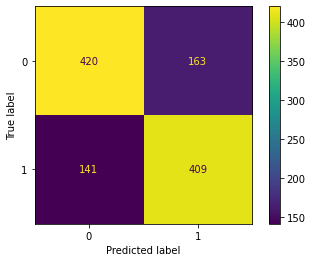

In [134]:
logreg = LogisticRegression() #Fit a logistic regression with default threshold
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test,y_pred))
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)) #Make Confusion Matrix
cm.plot()

In [135]:
y_pred = logreg.predict_proba(X_test) 
y_pred = y_pred[::,1]#Extract sigmoid probabilities
fpr, tpr, _ = roc_curve(y_test,  y_pred) #Calculate fpr and tpr for each threshold to make roc curve
auc = roc_auc_score(y_test, y_pred) #Get AUC to evaulate model
auc #AUC of roughly .8 Model performs fairly well

0.780474037112116

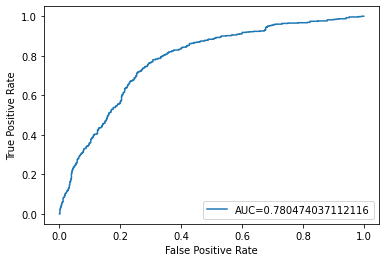

In [136]:
plt.plot(fpr,tpr,label="AUC="+str(auc)) #Plot ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [137]:
optimal_idx = np.argmax(tpr - fpr) #Find the optimal threshold
optimal_threshold = _[optimal_idx]
optimal_threshold

0.4703909878494021

In [138]:
y_pred = (y_pred > optimal_threshold).astype(int) #Compare probabilites to optimal threshold for classification

In [139]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       583
           1       0.70      0.78      0.74       550

    accuracy                           0.73      1133
   macro avg       0.74      0.73      0.73      1133
weighted avg       0.74      0.73      0.73      1133



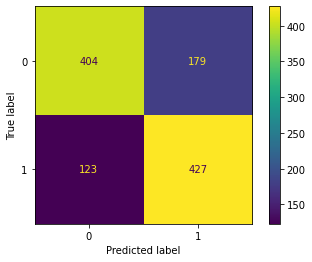

In [140]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)) #Make Confusion Matrix
cm.plot()

The optimal threshold is close to .5 so for simplicity sake, let's implement the built in .5 threshold model.

In [15]:
pickle.dump(logreg, open("logreg.pkl", "wb"))

In [56]:
df.max(axis = 0)

Owners                     1.000000
Age                        4.673688
selling_price             15.786370
km_driven                 15.584494
fuel_Diesel                1.000000
fuel_Petrol                1.000000
seller_type_Dealer         1.000000
seller_type_Individual     1.000000
transmission_Manual        1.000000
dtype: float64

In [57]:
df.min(axis = 0)

Owners                    0.000000
Age                      -1.718584
selling_price            -0.828437
km_driven                -1.498339
fuel_Diesel               0.000000
fuel_Petrol               0.000000
seller_type_Dealer        0.000000
seller_type_Individual    0.000000
transmission_Manual       0.000000
dtype: float64